In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys
sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/visualisation')
sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/deeplearningModel')
import json_ImExport
import LogDataImport
import random
import matplotlib.pyplot as plt
import scoreModel



torch.manual_seed(0)

## Data Import

In [2]:
#Json
#Jsondata=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")

#Log File (Monteblanco)
Logdata_MB=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")

#Log File (Berlin)
ValLogdata_B=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/12_19_36_data.csv")

#Log File (Modena)
ValLogdata_M=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_41_27_data.csv")

#Log File (zalazone)
ValLogdata_Z=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_51_25_data.csv")

#print(ValLogdata_Z)

## Define NN Model

In [21]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(99,300)
        self.fc2 = nn.Linear(300,200)
        self.fc3 = nn.Linear(200,150)
        self.fc4 = nn.Linear(150,98)

    def forward(self,x):
        x = F.leaky_relu(self.fc1(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc3(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc4(x),negative_slope=0.05)
        
        return x

model=DNN()

## Data Preperation

In [28]:



class Normalize():

    def __init__(self,data,scale=None):

        if scale is None:
            self.max=np.max(np.abs(data))
        else:
            self.max=scale
        print("Max is: ",self.max )

    def __call__(self,x):
        return x/self.max

    def normal(self,x):
        return x*self.max

# For Json
def prepareData(data):
    
    prepareddata=[]
    for item in data:

        #Input Data --------------------
        inpdata=[]
        inpdata.append(item["v_ini"])
        inpdata.append(item["v_max"])
        inpdata.append(item["Power"])   
        inpdata.extend(item["Kappa"])

        #Label Data -------------------
        label=item["V_op"]

        #Convert to Tensors -----------
        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(label)


        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    

    return prepareddata

# For Log File
def prepareLogData(indata):
    lowestLen=200
    low= 200
    prepareddata=[]

    #allkappa=[]
    #for item in data:
    #    allkappa.extend(item[0])
    
    #Initialize Nomalizer
    #kappaNormalize=Normalize(allkappa)
    kappaNormalize=Normalize(None,scale=0.044784975560085524)
    VelNormalize=Normalize(None,scale=70)
    data=[]
    for d in indata:

        data.extend(d)


    for item in data:
        inpdata=[]
        lowestLen= len(item[1]) if len(item[1])< lowestLen else lowestLen

        #Input Data --------------------
        inpdata.append(VelNormalize(item[1][0]))
        kappatmp=np.array(item[0][:98])
        label=np.array(item[1][:98])

        while len(kappatmp)<98:
            kappatmp=np.append(kappatmp,kappatmp[-1])
            label=np.append(label,label[-1])

        kappatmp=kappaNormalize(kappatmp)
        inpdata.extend(kappatmp) #Kappa

        low = len(inpdata) if len(indata)< low else low
        
        #Label Data -------------------


        #Convert to Tensors -----------
        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(VelNormalize(label))

        

        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
        
    print(low)
    return prepareddata

traindata=prepareLogData([Logdata_MB])
valdata=prepareLogData([ValLogdata_B,ValLogdata_M,ValLogdata_Z])
#print(traindata[1])

random.shuffle(traindata)
random.shuffle(valdata)


Max is:  0.044784975560085524
Max is:  70
99
Max is:  0.044784975560085524
Max is:  70
99


In [81]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

OUTSHOW=None

num_epochs = 2250
#train_tracker, val_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    random.shuffle(traindata)
    
    for batch, (inp, vel) in enumerate(traindata,1):

        optimizer.zero_grad()
        output = model(inp)

        loss = criterion(output, vel)

        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        

    train_tracker.append(cum_loss/len(traindata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(traindata)} | " ,end="")
    
    test_loss = 0
    num_correct = 0
    total = 0

    random.shuffle(valdata)
    for batch, (inp, vel) in enumerate(valdata,1):
        
        output = model(inp)
        batch_loss = criterion(output, vel)        
        test_loss += batch_loss.item()
    
        
    
    val_tracker.append(test_loss/len(valdata))
    print(f"Val loss: {test_loss/len(valdata)} | ")


32025642643 | 
Epoch(2030/2250) | Training loss: 0.0014201090931057522 |Val loss: 0.020496139461184573 | 
Epoch(2031/2250) | Training loss: 0.0014248461318627451 |Val loss: 0.020272195545374478 | 
Epoch(2032/2250) | Training loss: 0.0014313304008602731 |Val loss: 0.020184340768238582 | 
Epoch(2033/2250) | Training loss: 0.0014195572366030014 |Val loss: 0.020497354350180838 | 
Epoch(2034/2250) | Training loss: 0.001418884234896906 |Val loss: 0.020519704157633555 | 
Epoch(2035/2250) | Training loss: 0.0014187506191181568 |Val loss: 0.02023828923657393 | 
Epoch(2036/2250) | Training loss: 0.001413384662931066 |Val loss: 0.020417263221350453 | 
Epoch(2037/2250) | Training loss: 0.0014224685265794086 |Val loss: 0.020182709798050886 | 
Epoch(2038/2250) | Training loss: 0.0014247529538139326 |Val loss: 0.02041060006950567 | 
Epoch(2039/2250) | Training loss: 0.001418482231577372 |Val loss: 0.020176789830471182 | 
Epoch(2040/2250) | Training loss: 0.001418278835491214 |Val loss: 0.020329790469

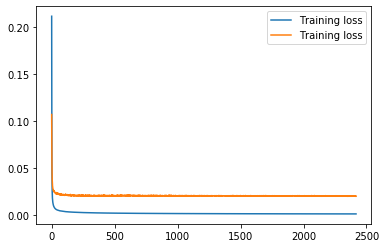

In [82]:
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(val_tracker, label='Training loss')

plt.legend()

In [5]:
def predict(testexample,NN=model):
    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    pData=testexample[0]
    pred=NN(pData[0])
    loss=criterion(pred,pData[1])

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(pData[1]))

    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    print("Loss:", loss.item())

from sklearn.metrics import r2_score
def r2Score(example):
    
    PRED=[]
    REAL=[] 
    for (inp,label) in example:
        pred=model(inp)
        PRED.append(pred.tolist())
        REAL.append(label.tolist())


    SCORE=r2_score(PRED,REAL,multioutput='variance_weighted')
    return SCORE

In [29]:
import time
import importlib
importlib.reload(scoreModel)
def evalmodel(inp):
    return model(inp)

Score=scoreModel.eval(evalmodel,valdata,70)



100%|██████████| 4680/4680 [00:04<00:00, 991.03it/s] MSE:  32.436317443847656



NameError: name 'R2Score' is not defined

{'R2': None, 'MAE': 29.276113510131836, 'MSE': 983.412109375}

Max is:  70
Evolived Time:  38.31887245178223 ms
Loss: 0.5990779399871826
The Score of the Train Dataset is:  {'R2': -11485.766838154283, 'MAE': 37.1624755859375, 'MSE': 1484.131591796875} %


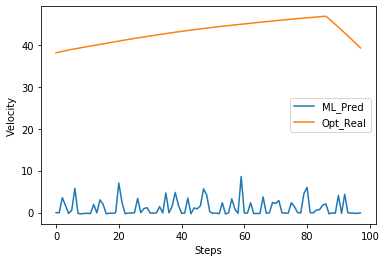

In [20]:
#The Visualisation
import time
NR=22

VelNormalize= Normalize(None,70)

criterion = nn.L1Loss()

#print(valdata[NR])
#testdata=torch.clone(traindata[NR][0])
testdata_inp=torch.clone(valdata[NR][0])
testdata_lable=torch.clone(valdata[NR][1])
#testdata=traindata[NR][0]
#testdata[:]=
#testdata[0]=0

#print(testdata)
t1=time.time()
pred=model(testdata_inp)
t2=time.time()

print("Evolived Time: " , (t2-t1)*1000,"ms")

loss=criterion(pred,valdata[NR][1])



%matplotlib inline

pred=VelNormalize.normal(np.array(pred.tolist()))
real=VelNormalize.normal(np.array(valdata[NR][1]))

#Score=r2Score(valdata)

plt.plot(pred,label="Pred")
plt.plot(real,label= "Real_Optimizer")

plt.legend(["ML_Pred","Opt_Real"])
#plt.title("| "+name + " | Total Score: "+str(np.round(Score,3))+"%"+ " | " )
plt.xlabel("Steps")
plt.ylabel("Velocity")

#scoreItem=r2_score(pred,valdata[NR][1])
#text= str(np.round(scoreItem,4))+ "% [score] | "+str(np.round(loss.item(),5)) +" [loss] "
MIN=min(pred)
#plt.text(76,MIN,text,horizontalalignment='center',verticalalignment='center')
print("Loss:", loss.item())


print("The Score of the Train Dataset is: ",Score,"%")

## Save Model

In [93]:
name="NN300200150_Iter250_MBZM"
save=True
PATH="/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/"+ name

In [95]:
#Save MODEL
if save:
    torch.save(model.state_dict(), PATH+".pt")
    torch.save(model,PATH+".pth")

/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
#Load MODEL with same Structure
model=DNN()
model.load_state_dict(torch.load("/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/NN300200150_Iter5000.pt"))
model.eval()

DNN(
  (fc1): Linear(in_features=99, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=98, bias=True)
)

In [27]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

FMNIST(
  (fc1): Linear(in_features=99, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=98, bias=True)
)

In [28]:
model2(traindata[37][0])

tensor([0.4575, 0.4608, 0.4637, 0.4666, 0.4696, 0.4724, 0.4753, 0.4767, 0.4799,
        0.4829, 0.4859, 0.4888, 0.4918, 0.4941, 0.4969, 0.4995, 0.5019, 0.5049,
        0.5078, 0.5101, 0.5133, 0.5148, 0.5181, 0.5206, 0.5234, 0.5262, 0.5287,
        0.5310, 0.5330, 0.5352, 0.5378, 0.5399, 0.5426, 0.5449, 0.5465, 0.5491,
        0.5521, 0.5545, 0.5560, 0.5584, 0.5608, 0.5627, 0.5647, 0.5666, 0.5685,
        0.5704, 0.5730, 0.5752, 0.5774, 0.5792, 0.5804, 0.5824, 0.5842, 0.5858,
        0.5876, 0.5889, 0.5910, 0.5925, 0.5943, 0.5962, 0.5970, 0.5989, 0.6001,
        0.6025, 0.6042, 0.6053, 0.6063, 0.6081, 0.6099, 0.6120, 0.6140, 0.6154,
        0.6171, 0.6182, 0.6194, 0.6209, 0.6222, 0.6232, 0.6241, 0.6263, 0.6270,
        0.6294, 0.6320, 0.6332, 0.6346, 0.6351, 0.6349, 0.6334, 0.6288, 0.6254,
        0.6186, 0.6104, 0.6013, 0.5901, 0.5793, 0.5687, 0.5589, 0.5489],
       grad_fn=<LeakyReluBackward0>)